In [1]:
import pandas as pd
import torch
import yaml
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from clamp.learning_model import CLAMP

100%|██████████| 1000/1000 [00:50<00:00, 19.91it/s]
0it [00:00, ?it/s]


final model MSE loss 6.08297867299284e-06
task transfer matrix
 [[ 1.          0.43037873  0.20552675  0.08976637 -0.1526904 ]
 [ 0.29178823  1.          0.783546    0.92732552 -0.23311696]
 [ 0.58345008  0.05778984  1.          0.85119328 -0.85792788]
 [-0.8257414  -0.95956321  0.66523969  1.          0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835  1.        ]]

0.8537749306176964,0.35489793217784815,0.09219423337339523,0.040004823090492136,-0.10199522315883673
0.24801656538651376,0.7996512924107855,0.36666637029482874,0.4474578286650722,-0.163110712807089
0.49598602232938144,0.04451914156994478,0.46214134110325056,0.4057172745085077,-0.596802977403658
-0.7326796566660193,-0.8039830216993326,0.3094368879621171,0.4811365529076981,0.5384975861166672
0.8991421069014842,0.3250537339000885,-0.9728567287757803,0.24569219109333895,0.3473192616715788

task transfer mse 0.11740062058175652

task difficulty 0.04302912952445249 [0.63992102 0.14335329 0.94466892 0.52184832 0.414661

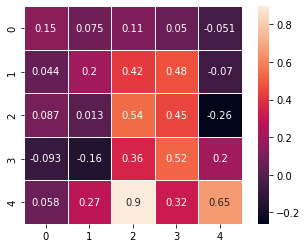

In [6]:

n_tasks=5
n_algos=3


np.random.seed(0)
torch.manual_seed(0)
ntasks = n_tasks
true_task_association = ((np.random.random((ntasks,ntasks))*2)-1)
true_task_difficulty = np.random.random(ntasks)
for i in range(ntasks):
    true_task_association[i,i] = 1

nalgos = n_algos
true_algo_efficiency = np.random.random(nalgos)
true_algo_memory = np.random.random(nalgos)
true_algo_experience_bonus = np.random.random(nalgos)
    
lx = []
slices = list()
order = np.random.randint(low=0, high=ntasks+1, size=9)
for i in order:
    before = len(lx)
    lx.extend([i])
    after = len(lx)
    slices.append([0,before,after,i])
#lx = [0,1,2,3,4,5,0,1,2,3,4,5 ]

model = CLAMP(nalgos,ntasks)
target = model.performance(ntasks,nalgos,true_task_association,lx,true_algo_efficiency,true_algo_memory,
                           true_algo_experience_bonus,true_task_difficulty)
#target = np_arr
model.optimize(lx,target,adam_iters=1000)

print('final model MSE loss', model.losses['loss'][-1])
print('task transfer matrix\n',true_task_association,)
print()
model.print_task_transfer()
transfer_difference = true_task_association - model.task_matrix.detach().numpy()
plt.imshow(transfer_difference, cmap='hot', interpolation='nearest')
ax = sns.heatmap(transfer_difference, linewidth=0.5,annot=True)
matrix_mse = (transfer_difference**2).mean(axis=None)
print('task transfer mse',matrix_mse)
print()
task_mse = ((true_task_difficulty - model.task_difficulty.detach().numpy())**2).mean(axis=None)
print('task difficulty',task_mse,true_task_difficulty,model.task_difficulty.detach().numpy())

transfer_mse = ((true_algo_efficiency - model.alg_efficiency.detach().numpy())**2).mean(axis=None)
print('algo transfer efficiency',transfer_mse,true_algo_efficiency,model.alg_efficiency.detach().numpy())

memory_mse = ((true_algo_memory - model.alg_memory_horizon.detach().numpy())**2).mean(axis=None)
print('algo memory horizon',memory_mse,true_algo_memory,model.alg_memory_horizon.detach().numpy())

expertise_mse = ((true_algo_experience_bonus - model.alg_experience_boost.detach().numpy())**2).mean(axis=None)
print('algo experience bonus',expertise_mse,true_algo_experience_bonus,model.alg_experience_boost.detach().numpy())


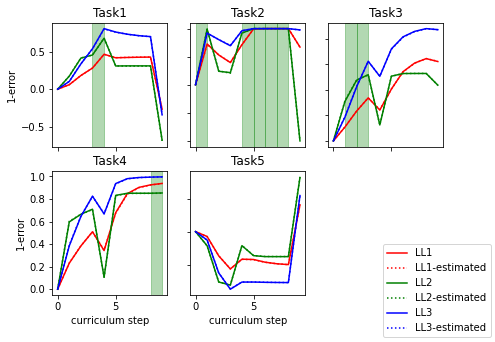

In [7]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ['Task1',"Task2","Task3","Task4","Task5"]
algos = ['LL1',"LL2","LL3"]
colors =['r','g','b']
prediction = model.prediction.detach().numpy()
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],colors[algo],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],colors[algo]+":",label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1-error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# MNIST Incremental Domain Analysis

In [9]:
files = [("GEM_1100",0.5),("GEM_4400",0.5),("EWC_online_mnist",700.0),("EWC_mnist",100.0),
("MAS",10000.0),("L2",0.5),("Naive_Rehearsal_1100",0.0),("Naive_Rehearsal_4400",0.0),("NormalNN",0.0),("SI",3000.0)]

np.random.seed(0)
torch.manual_seed(0)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=5
nalgos=len(files)
timepoints=5
minv = 50
maxv = 100 
lx = [0,1,2,3,4] # curriculum 
target = torch.from_numpy(np.zeros((nalgos,ntasks,len(lx)+1)))#2 algos,5 tasks, 6 timpoints

for algo in range(nalgos):
    with open('../data/mnist/'+files[algo][0]+'.yaml','r') as fname:
        data = yaml.load(fname, Loader=yaml.FullLoader)
        for task in range(ntasks):
            for t in range(len(lx)+1):
                val = data[files[algo][0]][files[algo][1]][0]['acc_table']['val'][str(t)][str(task+1)]
                normv = (val-minv)/(maxv-minv)
                target[algo,task,t] = normv

model2 = CLAMP(nalgos,ntasks)
model2.optimize(lx,target,adam_iters=1000)
print('final model MSE loss', model2.losses['loss'][-1])
model2.print_task_transfer()
prediction = model2.prediction.detach().numpy()
print()
print('task difficulty',model2.task_difficulty.detach().numpy())
print()
#print('algo transfer efficiency',model2.alg_efficiency.detach().numpy())
#print('algo memory horizon',model2.alg_memory_horizon.detach().numpy())
#print('algo experience bonus',model2.alg_experience_boost.detach().numpy())
algos = [files[algo][0] for algo in range(nalgos)]
model2.print_algo_results(algo_names=algos)


100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]
0it [00:00, ?it/s]

final model MSE loss 0.01894836849152597
0.9995232190542196,-0.011699504751628011,0.02663226976171454,0.04817458479389868,-0.1329573175134727
-0.37652210020181787,0.8802780143395881,0.07624206200176885,0.07292000517591733,0.11558607876572147
-0.1772821470206309,0.3775748427023075,0.9873380665373863,-0.08894108291227161,-0.35487020484226384
0.2677146586839036,-0.22268620658623678,-0.6606115352704474,1.0,0.4086342397947985
-0.16296090777703098,-0.016563185069295657,-0.19500218945739653,-0.16835678414453648,0.7507702312161905


task difficulty [0.10517275 0.11251304 0.10857495 0.08334181 0.25238968]

algorithm,efficiency,retention,expertice
GEM_1100,0.7929720390257968,0.9833707924138386,0.309025975990722
GEM_4400,0.8849315315032068,1.0,0.12433937014740198
EWC_online_mnist,0.9591598048598089,0.43737826527191404,0.5790057463698023
EWC_mnist,0.862164850071347,0.43109884006744403,0.5655510673813252
MAS,0.31940439934842924,0.9093804884307789,0.09466804604392248
L2,0.735457943177561,0.528163716

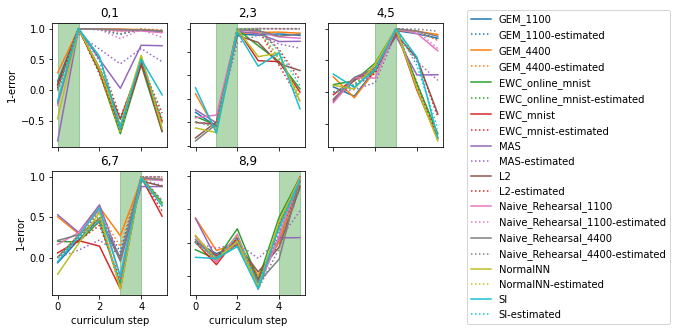

In [10]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ["0,1","2,3","4,5","6,7","8,9"]
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive',
        'tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1-error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.36, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## CIFAR100 Incremental Task Analysis

In [11]:
files = [("EWC_online",3000.0),("EWC",100.0),("MAS",10.0),("L2",1.0),("Naive_Rehearsal_1400",0.0),
         ("Naive_Rehearsal_5600",0.0),("NormalNN",0.0),("SI",2.0)]
np.random.seed(0)
torch.manual_seed(0)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=5
nalgos=len(files)
timepoints=6
minv = 0
maxv = 100 
lx = [0,1,2,3,4]
target = torch.from_numpy(np.zeros((nalgos,ntasks,timepoints)))#2 algos,5 tasks, 6 timpoints

for algo in range(nalgos):
    with open('../data/cifar100/'+files[algo][0]+'.yaml','r') as fname:
        data = yaml.load(fname, Loader=yaml.FullLoader)
        for task in range(ntasks):
            for t in range(timepoints):
                val = data[files[algo][0]][files[algo][1]][0]['acc_table']['val'][str(t)][str(task+1)]
                normv = (val-minv)/(maxv-minv)
                target[algo,task,t] = normv
#print(target)
model3 = CLAMP(nalgos,ntasks)
model3.optimize(lx,target,adam_iters=1000)
print('final model MSE loss', model3.losses['loss'][-1])
model3.print_task_transfer()
prediction = model3.prediction.detach().numpy()
print()
print('task difficulty',model3.task_difficulty.detach().numpy())
print()
algos=[files[algo][0] for algo in range(nalgos)]
model3.print_algo_results(algo_names=algos)

100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]
0it [00:00, ?it/s]

final model MSE loss 0.00242851413552006
0.9634795553341994,0.15141440452048252,0.06335674807008718,0.06743506175322404,0.03816034371988248
-0.5544723715222232,0.9068464571061189,0.005012509083935263,-0.009570788217934221,0.005802634654814033
0.0008321155496334885,-0.12799758934070524,1.0,0.007616133900095613,0.0038886537307689212
0.003331013658406694,0.0014472070413924698,-0.1166551250075091,1.0,0.005993442297282899
0.008353806301322085,0.08908040270863035,0.09860711895222093,-0.08424011961787396,1.0


task difficulty [0.02695261 0.27505134 0.27777132 0.29915731 0.25464402]

algorithm,efficiency,retention,expertice
EWC_online,0.34492772298786395,0.995409555802677,2.1123075268206946
EWC,0.6026213595940573,0.6126380374205792,0.0
MAS,0.3289957183514021,0.9416915075226773,1.0333236411921105
L2,0.12309321708864512,1.0,0.0
Naive_Rehearsal_1400,0.5744728119625049,0.8388400452485067,1.0368622107534329
Naive_Rehearsal_5600,0.5766811861719814,0.9069892220496023,1.3726456841906716
NormalNN,0.520

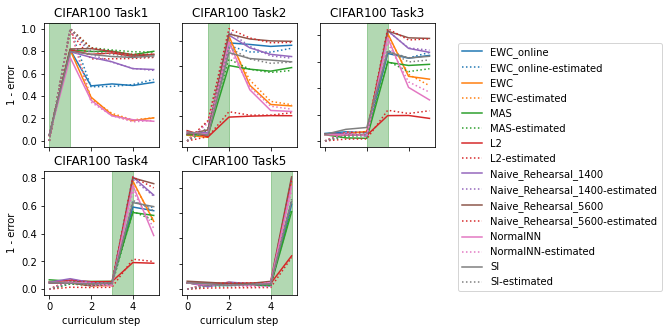

In [12]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1)]
tasks = ["CIFAR100 Task1","CIFAR100 Task2","CIFAR100 Task3","CIFAR100 Task4","CIFAR100 Task5"]
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive',
        'tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)


axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='1 - error')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.36, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## CRL Analysis

    step  clear   pnc  oewc  ewc  impala
0      0      0     0     0    0       0
1     50   2350   850   800  950     900
2    100   1000    50   100  500     100
3    150   1200   250   150  500     100
4    200   1050   300   150  500     100
5    250   1000    50   100  500     100
6    300    900    50   100  500     100
7    350   2800  1000   750  500    1200
8    400   2500   250   200  500     200
9    450   2400   200   200  500     250
10   500   2300   250   200  500     200
11   550   1900   150   200  500     150
12   600   1950   150   200  500     150
    step  clear   pnc  oewc   ewc  impala
0      0      0     0     0     0       0
1     50    500   500     0  1000       0
2    100   8750  6500  6500  2000    7000
3    150   6500  1000  2000  2250    1850
4    200   6750  1000  1850  2250       0
5    250   7000   500   500  1750    1800
6    300   6500   500  1250  1750    1000
7    350   6500  1000  1750  2000    1500
8    400   9500  6500  6500  2000    8000
9    4

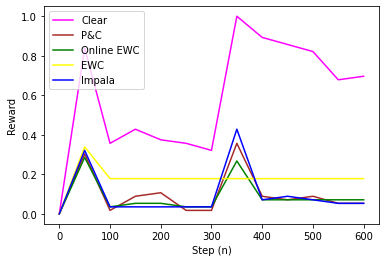

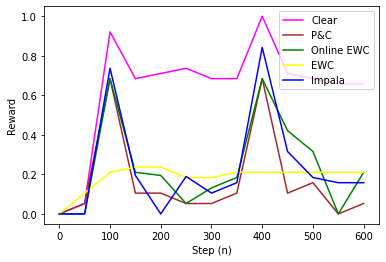

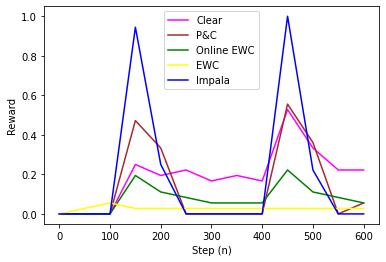

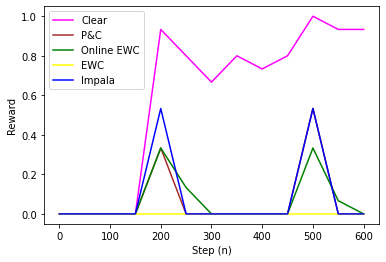

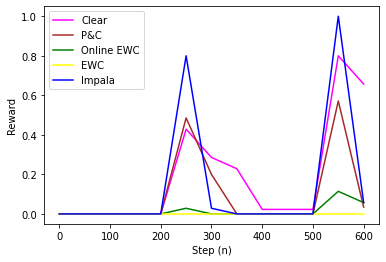

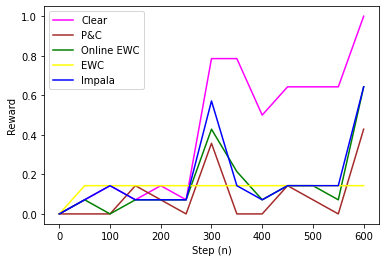

torch.Size([5, 6, 13])


In [13]:
n_tasks = 6
n_steps = 13
n_algos = 5
np_arr = np.zeros([n_algos,n_tasks,n_steps])
for i in range(6):
    stri = 'df' + str(i)
    readfile = '../data/atari/game' + str(i) + '.csv'
    df = pd.read_csv(readfile)
    exec(f"{stri} = df")
    M = df.iloc[:,1:].max().max()

    plt.figure(i) 
    plt.plot(df["step"],df["clear"]/M,color = 'magenta',label = "Clear")
    plt.plot(df["step"],df["pnc"]/M,color = 'brown',label = "P&C")
    plt.plot(df["step"],df["oewc"]/M,color = 'green',label = "Online EWC")
    plt.plot(df["step"],df["ewc"]/M,color = 'yellow',label = "EWC")
    plt.plot(df["step"],df["impala"]/M,color = 'blue',label = "Impala")
    plt.xlabel('Step (n)')
    plt.ylabel('Reward')
    plt.legend()

    dfnp = df.to_numpy()[:,1:]
    print(df)
    np_arr[:,i,:] = dfnp.transpose() / M 
    #fname = '.\data\crl\images\game_'+str(i)+'.png'
    #plt.savefig(fname)

plt.show()
targ = torch.tensor(np_arr.astype(float))
print(targ.shape)

In [14]:

np.random.seed(1)
torch.manual_seed(1)
#print(data['MAS'][10000][0]['acc_table']['val'].keys())
ntasks=6
nalgos=5
timepoints=13
minv = 10
maxv = 200 
lx = [0,1,2,3,4,5,0,1,2,3,4,5] # curriculum 
target = targ

model4 = CLAMP(nalgos,ntasks)
model4.optimize(lx,target,adam_iters=1000)
print()
print('final model MSE loss', model4.losses['loss'][-1])
model4.print_task_transfer()
prediction = model4.prediction.detach().numpy()
print()
print('task difficulty',model4.task_difficulty.detach().numpy())
print()
model4.print_algo_results(algo_names=['Clear','P&C','Online EWC', 'EWC','Impala'])

100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]
0it [00:00, ?it/s]


final model MSE loss 0.006517710911313894
1.0,0.1800033491144887,-0.14835007909098158,0.012216055355125908,-0.16222456724296946,0.01964430125075155
-0.09163224068758541,1.0,0.1951609268769414,-0.03960064294269549,-0.03955011889016698,0.01969771965454514
0.047974989008673266,-0.16844954348789612,1.0,0.0011501724230761191,0.024072394892439494,0.07568547497111601
0.11753688891426196,0.045227492637000315,-0.3458185500653695,1.0,0.1399880398078328,0.1034252628504496
0.0013639710116694417,0.07280071204719589,-0.16307756597934614,-0.11347249843692889,0.9985374315294104,-0.02395483151051492
-0.027625462500674488,0.051757429496956296,-0.006188488687370709,-0.005612900146698789,-0.3970935730062968,1.0


task difficulty [0.08992913 0.08070891 0.15292737 0.04184255 0.09525863 0.08395594]

algorithm,efficiency,retention,expertice
Clear,0.1298189557794709,0.9055650710198684,0.02797856296989157
P&C,0.06571359143814194,0.3545685761027211,1.155815055532674
Online EWC,0.038744311632614686,0.60921401745

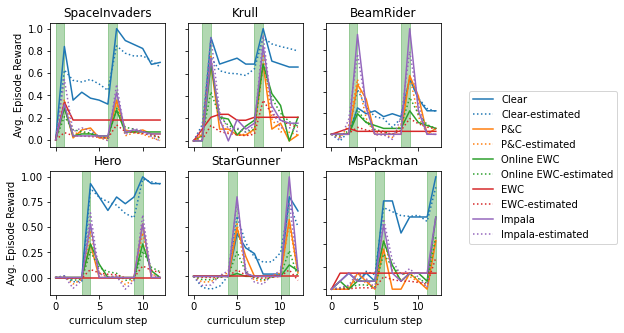

In [15]:
panels = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
tasks = ["SpaceInvaders","Krull","BeamRider","Hero",'StarGunner',"MsPackman"]
algos = ['Clear','P&C','Online EWC', 'EWC','Impala']
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:red','tab:pink','tab:grey','tab:olive',
        'tab:cyan','tab:brown']

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(7, 5)
x = range(target.shape[-1])
for i,panel in enumerate(panels):
    axs[panel].set_title(tasks[i])
    for algo in range(nalgos):  
        axs[panel].plot(x, target[algo,i,:],label=algos[algo])
        axs[panel].plot(x, prediction[algo,i,:],":",c=colors[algo],label=algos[algo]+"-estimated")

for i,panel in enumerate(panels):
    for j,curr in enumerate(lx):
        if curr == i:
            axs[panel].axvspan(j, j+1, color="green", alpha=0.3)
            


#axs[1,2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='curriculum step', ylabel='Avg. Episode Reward')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels,  loc="center right", bbox_to_anchor=(1.26, .48))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

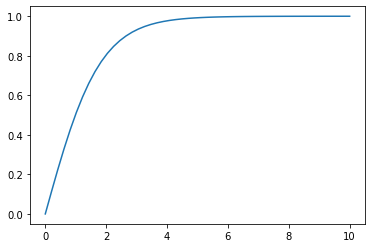

In [16]:
x = np.linspace(0,10)
y = (1/(1+(np.exp(-1*x/.90)))*2)-1
plt.plot(x,y)
plt.show()